In [2]:
#we first collect the data, it should take a few seconds
!wget https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip

--2022-12-14 20:25:56--  https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip
Resolving vcla.stat.ucla.edu (vcla.stat.ucla.edu)... 128.199.9.172
Connecting to vcla.stat.ucla.edu (vcla.stat.ucla.edu)|128.199.9.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37324985 (36M) [application/zip]
Saving to: ‘AnimalFace.zip’

AnimalFace.zip      100%[===================>]  35.60M  45.6MB/s    in 0.8s    

2022-12-14 20:25:57 (45.6 MB/s) - ‘AnimalFace.zip’ saved [37324985/37324985]



In [3]:
#we unzip the data
!unzip -qq AnimalFace.zip -d Image

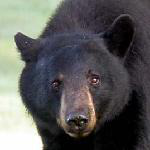

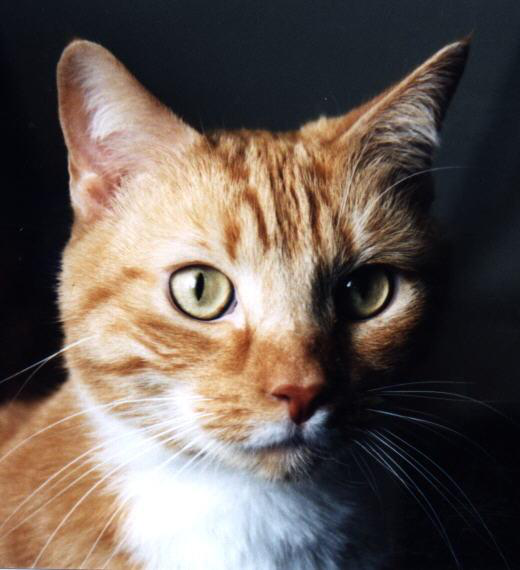

In [4]:
#we now see a few examples
from IPython.display import display
from PIL import Image

path="./Image/Image/BearHead/bearfrontal0001.jpg"
display(Image.open(path))

path="./Image/Image/CatHead/cat000852.jpg"
display(Image.open(path))

##LOAD THE DATA SET

In [5]:
import os
import numpy as np

In [6]:
#define a function that loads the given images
def load_image(x, x_size = 50, y_size = 50):
    #open the image
    img = Image.open(x)

    #resize
    img = img.resize((x_size, y_size), Image.ANTIALIAS)

    #convert to numpy array
    img = np.asarray(img)

    return img

In [7]:
#load the images
animals_x = []
animals_y = []

#generate the list of paths
bear_paths = [f"Image/Image/BearHead/{x}" for x in os.listdir('Image/Image/BearHead/')]
cat_paths = [f"Image/Image/CatHead/{x}" for x in os.listdir('Image/Image/CatHead/')]
chicken_paths = [f"Image/Image/ChickenHead/{x}" for x in os.listdir('Image/Image/ChickenHead/')]
cow_paths = [f"Image/Image/CowHead/{x}" for x in os.listdir('Image/Image/CowHead/')]
deer_paths = [f"Image/Image/DeerHead/{x}" for x in os.listdir('Image/Image/DeerHead/')]

print(len(bear_paths), len(cat_paths), len(chicken_paths), len(cow_paths), len(deer_paths))

for x in bear_paths:
    img = load_image(x)
    animals_x.append(img)
    animals_y.append("bear")

for x in cat_paths:
    img = load_image(x)
    animals_x.append(img)
    animals_y.append("cat")

for x in chicken_paths:
    img = load_image(x)
    animals_x.append(img)
    animals_y.append("chicken")

for x in cow_paths:
    img = load_image(x)
    animals_x.append(img)
    animals_y.append("cow")

for x in deer_paths:
    img = load_image(x)
    animals_x.append(img)
    animals_y.append("deer")

101 160 100 104 103


In [8]:
print(animals_x[1].shape)
print(set(animals_y))

(50, 50, 3)
{'bear', 'chicken', 'cow', 'cat', 'deer'}


In [9]:
from sklearn.model_selection import train_test_split
#define the training, validation, and testing sets
# Split data into 80% train and 20% test subsets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    animals_x, animals_y, test_size=0.2, shuffle=True, random_state = 123
)

# Split data into 80% train and 20% test subsets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state = 123
)

In [12]:

from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])


class Flatter(BaseEstimator, TransformerMixin):
    """
    Flat an image from 3D to 2D
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array(X).reshape(len(X), -1)

In [14]:
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([
    ('hog', HogTransformer()),
    ('flatter', Flatter()) 
])

In [15]:
#Preprocessing step (transforming and flattening)
X_train_prep = preprocessing.fit_transform(X_train)
X_val_prep = preprocessing.fit_transform(X_val)
X_test_prep = preprocessing.fit_transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#train the logistic regression
log_grid_params = {
    'C': [0.5, 1, 5],
}
log_clf = LogisticRegression(random_state=123, max_iter=400)
log_v1 = GridSearchCV(estimator= log_clf, param_grid=log_grid_params, cv = 5, scoring = "accuracy")
log_v1.fit(X_train_prep,y_train)

#train the KNN
knn_grid_params = {
    'n_neighbors': list(range(10)),
    'p': [2],
    'metric': ['minkowski'],
}
knn_clf = KNeighborsClassifier()
knn_v1 = GridSearchCV(estimator=knn_clf, param_grid=knn_grid_params, n_jobs=-1, cv=5)
knn_v1.fit(X_train_prep,y_train)

#train the decision tree
dt_grid_params = {
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
}

dt_clf = DecisionTreeClassifier(random_state= 123)
dt_v1 = GridSearchCV(dt_clf, dt_grid_params, n_jobs= -1, cv = 5)
dt_v1.fit(X_train_prep, y_train)

#train the random forest
rf_grid_params = {
    'n_estimators': [5, 10, 20],
    'criterion': ['entropy'],
    'max_depth': [None, 3, 5, 10],
}
rf_clf = RandomForestClassifier(random_state= 123)
rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
rf_v1.fit(X_train_prep, y_train)

#train the svc
svc_grid_params = {
    'C': [0.1, 1., 10],
    'kernel': ('rbf', 'linear'),
    'gamma': [0.001, 0.1, 10, 100, 500]
}
svc_clf = SVC(random_state= 123)
svc_v1 = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)
svc_v1.fit(X_train_prep, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expected

GridSearchCV(cv=5, estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10],
                         'gamma': [0.001, 0.1, 10, 100, 500],
                         'kernel': ('rbf', 'linear')})

In [26]:


#it's time who is the winner
y_train_pred = log_v1.predict(X_train_prep)
y_val_pred = log_v1.predict(X_val_prep)
print(f"Logistic regression.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

y_train_pred = knn_v1.predict(X_train_prep)
y_val_pred = knn_v1.predict(X_val_prep)
print(f"KNN.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

y_train_pred = dt_v1.predict(X_train_prep)
y_val_pred = dt_v1.predict(X_val_prep)
print(f"Decision Tree.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

y_train_pred = rf_v1.predict(X_train_prep)
y_val_pred = rf_v1.predict(X_val_prep)
print(f"Random Forest.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")


y_train_pred = svc_v1.predict(X_train_prep)
y_val_pred = svc_v1.predict(X_val_prep)
print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred, average = 'macro'):.4f}")

Logistic regression.	Train:0.9950	Val:0.8982
KNN.	Train:0.9220	Val:0.8336
Decision Tree.	Train:1.0000	Val:0.5562
Random Forest.	Train:1.0000	Val:0.7500
SVC.	Train:1.0000	Val:0.9197


##Training Neural Networks

In [28]:
### -------------- SOLUTION ---------------
import numpy as np
import tensorflow #the backend used by Keras (there are different beckend)
from tensorflow.keras.models import Sequential #import the type of mpdel: sequential (e.g., MLP)
from tensorflow.keras.layers import Input, Dense #simple linear layer
from tensorflow.keras.utils import to_categorical # transformation for classification labels
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

#importin early stopping mecanism
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

#define the NN settings
feature_vector_length = len(X_train_prep[0])
print(feature_vector_length)
num_classes = 5

#convert the ground truth from textual to numerical representation
animal2num = {
    'bear': 0,
    'cat': 1,
    'chicken': 2,
    'cow': 3,
    'deer': 4
}
y_train_num = [animal2num[x] for x in y_train]
y_val_num = [animal2num[x] for x in y_val]

#convert the ground truth from numerical to cateogrical representation
y_train_cat = to_categorical(y_train_num, num_classes)
y_val_cat = to_categorical([y_val_num for x in y_val], num_classes)

np.random.seed(123)
set_random_seed(2)

model = Sequential() #we first define how the "model" looks like
model.add(Dense(input_dim = feature_vector_length, units=feature_vector_length , activation='relu')) #input layer
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(num_classes, activation='softmax')) #output layer

print(model.summary())

# Configure the model and start training
model.compile(loss='categorical_crossentropy', #loss metric
    optimizer='sgd',  #optimizer
    metrics=['accuracy']) #displayed metric

history = model.fit(X_train_prep, y_train_cat, epochs=500, batch_size=16, verbose=0, validation_split=0.1, callbacks=[es])

y_train_pred =model.predict(X_train_prep).argmax(axis = 1) 
y_val_pred = model.predict(X_val_prep).argmax(axis = 1)
print(f"NN.\tTrain:{f1_score(y_train_num, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val_num, y_val_pred,average = 'macro'):.4f}")


1296
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1296)              1680912   
                                                                 
 dense_4 (Dense)             (None, 256)               332032    
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,014,229
Trainable params: 2,014,229
Non-trainable params: 0
_________________________________________________________________
None
Epoch 55: early stopping
3/3 [==============================] - 0s 11ms/step
NN.	Train:0.9685	Val:0.8529
